Processing Segmentation...
Processing Parkinsons...


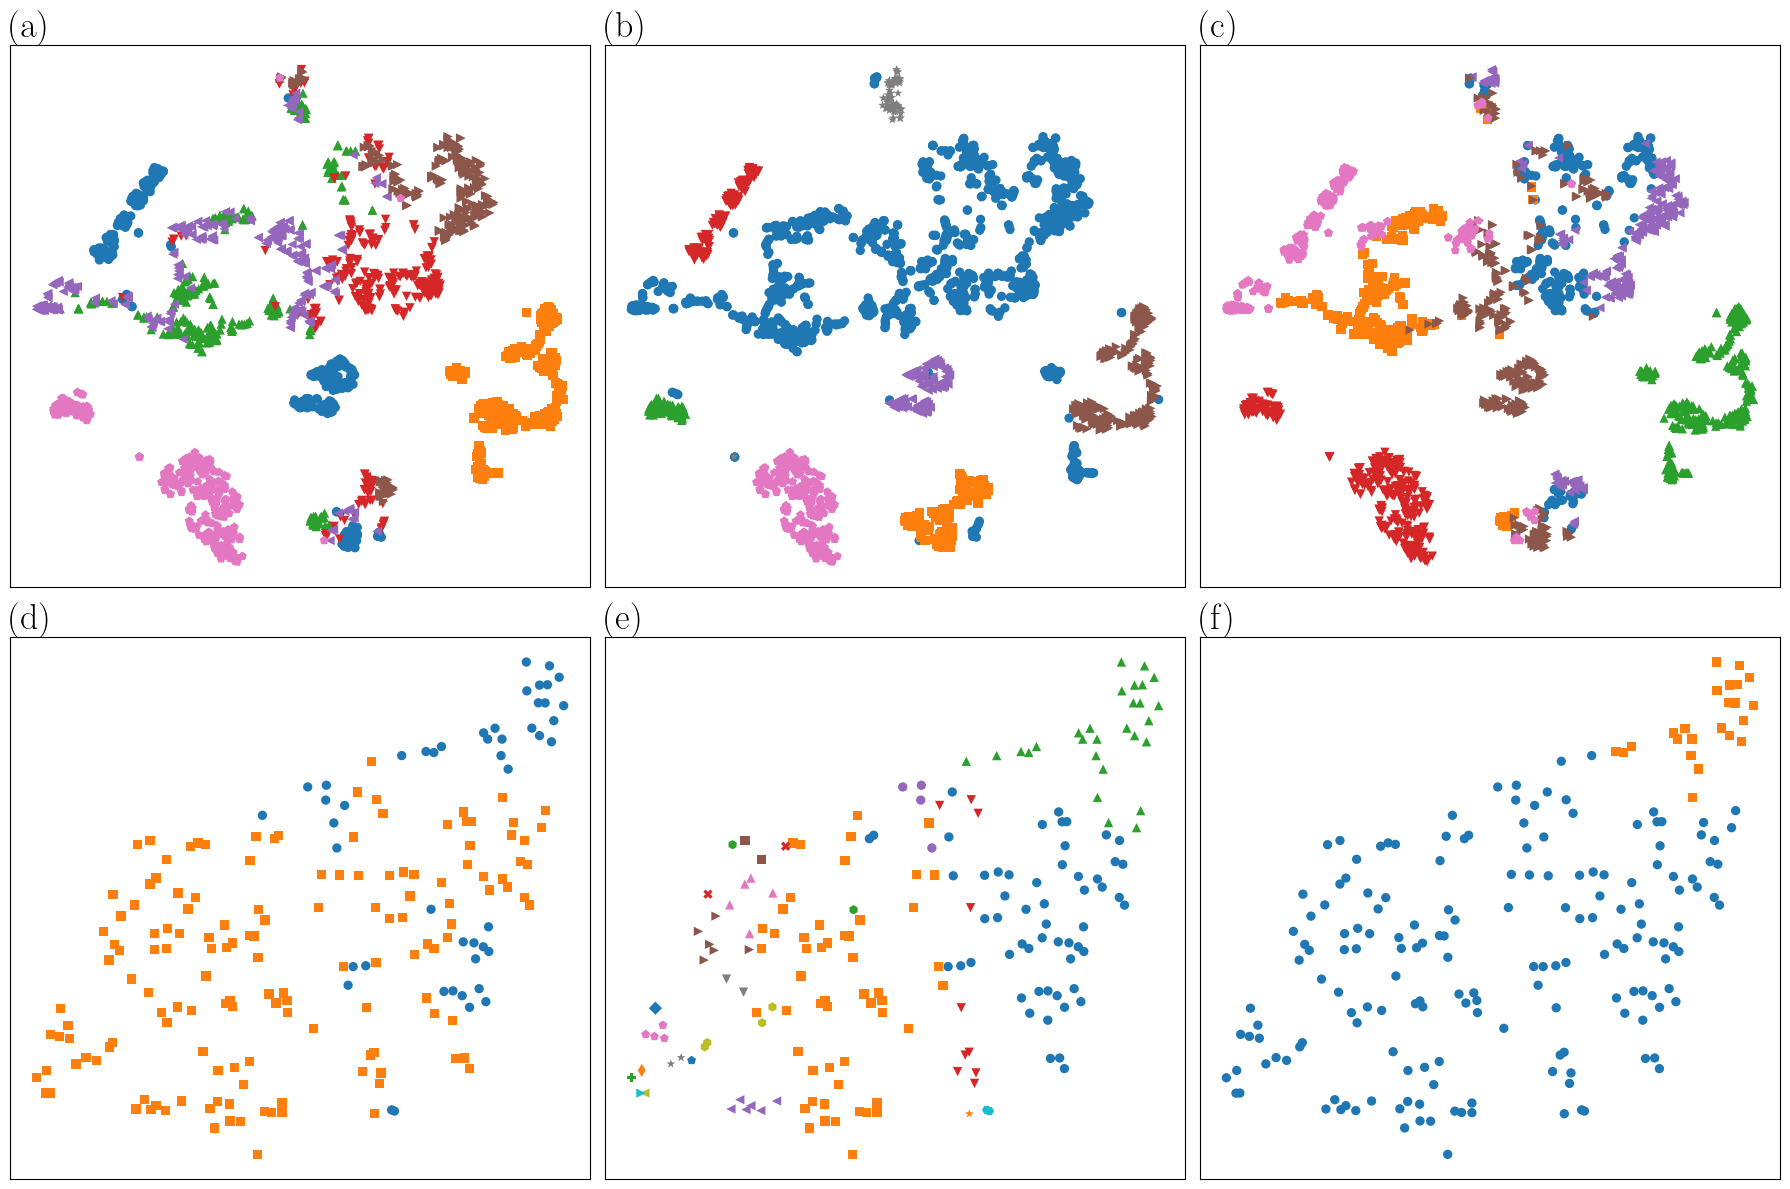

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set up paths
DATASET_DIR = Path("datasets/real_world")
RESULTS_FILE = Path("results/DAPINet_results.csv")
ORACLE_ARI_FILE = Path("results/oracle_ari.csv")

datasets = ["Segmentation", "Parkinsons"]

# Load configuration files
deep_model_df = pd.read_csv(RESULTS_FILE)
oracle_ari_df = pd.read_csv(ORACLE_ARI_FILE)

def get_deep_model_algo(dataset_name):
    row = deep_model_df[deep_model_df['dataset'] == dataset_name]
    if not row.empty:
        return row.iloc[0]['selected_algorithm']
    return None

def get_oracle_best_algo(dataset_name):
    row = oracle_ari_df[oracle_ari_df['dataset'] == dataset_name]
    if not row.empty:
        algos = row.drop(columns=['dataset'])
        return algos.idxmax(axis=1).values[0]
    return None

def plot_clusters(ax, X, labels, title):
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.arange(len(unique_labels)) % 10)
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(X[mask, 0], X[mask, 1],
                   c=[colors[idx]],
                   marker=markers[idx % len(markers)],
                   s=45,
                   edgecolors='none')
    ax.set_title(title, loc='left')
    ax.set_xticks([])
    ax.set_yticks([])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.titlesize": 26,
    "axes.labelsize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plot_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

for i, dataset_name in enumerate(datasets):
    print(f"Processing {dataset_name}...")

    # Load dataset
    npz_path = os.path.join(DATASET_DIR, f"{dataset_name}.npz")
    data = np.load(npz_path)
    X, y_gt = data['X'], data['y']

    deep_algo = get_deep_model_algo(dataset_name)
    oracle_algo = get_oracle_best_algo(dataset_name)

    y_deep = data[deep_algo] if deep_algo in data else np.zeros(X.shape[0])
    y_oracle = data[oracle_algo] if oracle_algo in data else np.zeros(X.shape[0])

    # Compute t-SNE
    X_norm = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_norm)

    # Plotting
    plot_clusters(axes[i, 0], X_embedded, y_gt, plot_labels[i*3])
    plot_clusters(axes[i, 1], X_embedded, y_deep, plot_labels[i*3+1])
    plot_clusters(axes[i, 2], X_embedded, y_oracle, plot_labels[i*3+2])

plt.tight_layout()
plt.savefig("results/figures/failure_cases.pdf", format="pdf", dpi=600, bbox_inches="tight")
plt.show()
